# Forecasting dengan Auto Corelation

## - Apa itu Forecasting?

Bayangkan Anda adalah seorang kapten kapal yang mencoba menavigasi lautan yang tidak pasti di depan. Untuk tahu ke mana harus berlayar, Anda tidak bisa hanya menebak-nebak; Anda harus melihat ke belakang, mempelajari catatan perjalanan sebelumnya, menganalisis pola angin musiman, dan data arus laut yang telah dikumpulkan. Inilah inti dari forecasting (peramalan): sebuah proses sistematis untuk memprediksi apa yang akan terjadi di masa depan dengan cara menggali dan menganalisis data historis serta tren masa lalu. Baik itu untuk memperkirakan cuaca besok, penjualan produk bulan depan, atau, seperti dalam kasus Anda, memprediksi tingkat polusi $NO_2$, tujuannya selalu sama—yaitu menggunakan wawasan dari masa lalu untuk mengurangi ketidakpastian dan membantu kita mengambil keputusan yang lebih cerdas dan lebih siap hari ini.

## - Mengapa Forecasting penting?

Pada intinya, kita melihat pola-pola yang terjadi di masa lalu (seperti tren musiman, siklus, atau kebiasaan) dan menggunakan pola tersebut untuk membuat perkiraan yang logis tentang apa yang akan terjadi selanjutnya.Tujuan utamanya adalah untuk mengurangi ketidakpastian dalam pengambilan keputusan. Dengan memiliki perkiraan yang berbasis data, sebuah organisasi atau individu dapat membuat perencanaan yang lebih matang, mengantisipasi risiko, dan mengalokasikan sumber daya secara lebih efisien.

## - Crawling Data

### 1. Import libarary yang dibutuhkan

In [1]:
import openeo
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()
print("Connected to Copernicus Data Space Ecosystem")

Authenticated using refresh token.
Connected to Copernicus Data Space Ecosystem


### 2. Definisi kan koordinat di wilayah Kamal dan parameter waktu (2022-2025)

In [2]:
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              112.71199080623381,
              -7.151070739706199
            ],
            [
              112.71199080623381,
              -7.168985131602568
            ],
            [
              112.73980259222657,
              -7.168985131602568
            ],
            [
              112.73980259222657,
              -7.151070739706199
            ],
            [
              112.71199080623381,
              -7.151070739706199
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

# Define spatial extent from AOI coordinates
spatial_extent = {
    "west": 112.71199080623381,
    "south": -7.168985131602568,
    "east": 112.73980259222657,
    "north": -7.151070739706199
}

start_date = "2022-10-23"
end_date = "2025-10-23"

print(f"AOI defined for coordinates: {spatial_extent}")
print(f"Time range: {start_date} to {end_date}")
print("Setup completed successfully")

AOI defined for coordinates: {'west': 112.71199080623381, 'south': -7.168985131602568, 'east': 112.73980259222657, 'north': -7.151070739706199}
Time range: 2022-10-23 to 2025-10-23
Setup completed successfully


### 3. Loading data Sentinel-5P NO2 dan agregasi temporal harian

In [3]:
print("Loading Sentinel-5P NO2 data...")

s5p_no2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=[start_date, end_date],
    spatial_extent=spatial_extent,
    bands=["NO2"],
)

s5p_monthly = s5p_no2.aggregate_temporal_period(
    period="day",
    reducer="mean"
)

print("Data collection and aggregation configured successfully")

Loading Sentinel-5P NO2 data...


Data collection and aggregation configured successfully


### 4. Melakukan eksekusi job batch processing untuk memproses data secara otomatis dan terjadwal, kemudian mengekspor hasilnya ke dalam format file NetCDF

In [4]:
print("Starting data processing job...")

job = s5p_monthly.execute_batch(
    title="NO2 Averages 2021-2025", 
    outputfile="no2_averages_4years.nc"
)


Starting data processing job...


0:00:00 Job 'j-2511211408464bab98e306975b0a3509': send 'start'


0:00:14 Job 'j-2511211408464bab98e306975b0a3509': created (progress 0%)


0:00:19 Job 'j-2511211408464bab98e306975b0a3509': created (progress 0%)


0:00:26 Job 'j-2511211408464bab98e306975b0a3509': running (progress N/A)


### 5. Ubah data NetCDF ke CSV agar lebih mudah untuk digunakan

In [3]:
# 1. Buka file .nc Anda
# Ganti 'openEO.nc' jika nama filenya berbeda
ds = xr.open_dataset("C:\\Dokumen\\PSD\\dataset\\openEO.nc")

# 2. Konversi dataset xarray menjadi DataFrame pandas
df = ds.to_dataframe()

# 3. [PENTING] Ratakan Multi-Index
# Data NetCDF biasanya punya banyak index (spt waktu, lat, lon).
# 'reset_index()' akan mengubah semua index itu menjadi kolom biasa.
df_flat = df.reset_index()

# 4. Simpan sebagai file CSV
df_flat.to_csv('hasil_data_no2.csv', index=False)

print("Selesai! File 'hasil_data_no2.csv' telah dibuat.")

Selesai! File 'hasil_data_no2.csv' telah dibuat.


## - Preprocessing

### - Mengurutkan Data berdasarkan tanggal/waktu

Mengurutkan data berdasarkan tanggal/waktu (sortir kronologis) adalah langkah preprocessing yang fundamental, terutama untuk data time-series (data berurutan).

Ini penting karena mengubah data yang acak menjadi sebuah alur cerita yang logis.

Tujuannya adalah untuk memastikan bahwa setiap observasi (baris data) ditempatkan dalam urutan yang benar sesuai kejadiannya. Tanpa pengurutan ini, analisis seperti mencari tren, mengidentifikasi pola musiman, atau melakukan interpolasi (mengisi data hilang) akan menghasilkan kesimpulan yang salah, karena hubungan antar-waktu antar-titik data menjadi rusak.

In [3]:
# 1. Baca file CSV
df = pd.read_csv('hasil_data_no2.csv')

# 2. Ubah kolom 't' menjadi format datetime
df['t'] = pd.to_datetime(df['t'])

# 3. Urutkan DataFrame berdasarkan kolom 't'
df_sorted = df.sort_values(by='t')

# 4. Menampilkan hasil pengirutan
print(df_sorted)

print("Selesai! Data telah diurutkan berdasarkan waktu dan disimpan di 'hasil_data_no2_sorted.csv'")

              t           x         y  crs       NO2
0    2022-10-23  112.739273 -7.151624  b''  0.000030
1    2022-10-24  112.739273 -7.151624  b''       NaN
2    2022-10-25  112.739273 -7.151624  b''  0.000070
3    2022-10-26  112.739273 -7.151624  b''       NaN
4    2022-10-27  112.739273 -7.151624  b''       NaN
...         ...         ...       ...  ...       ...
1085 2025-10-18  112.739273 -7.151624  b''  0.000015
1086 2025-10-19  112.739273 -7.151624  b''  0.000056
1087 2025-10-20  112.739273 -7.151624  b''       NaN
1088 2025-10-21  112.739273 -7.151624  b''       NaN
1089 2025-10-22  112.739273 -7.151624  b''       NaN

[1090 rows x 5 columns]
Selesai! Data telah diurutkan berdasarkan waktu dan disimpan di 'hasil_data_no2_sorted.csv'


### - Mengatasi Missing Value dengan interpolasi

Mengatasi *missing value* (data hilang) dengan **interpolasi** adalah teknik *preprocessing* untuk "menebak" nilai yang hilang secara cerdas.

Cara kerjanya adalah dengan **melihat nilai-nilai tetangga yang diketahui** (misalnya, nilai sebelum dan sesudah data yang hilang) dan menarik garis lurus (atau kurva) di antara keduanya. Nilai yang hilang kemudian diisi dengan titik yang jatuh tepat di atas garis tersebut.

Ini adalah metode yang sangat umum untuk data *time-series* (seperti data cuaca atau polusi) karena metode ini **mempertahankan kelancaran dan tren data** dari waktu ke waktu, alih-alih hanya mengisi dengan nilai rata-rata atau membuang baris data.

In [4]:
df['t'] = pd.to_datetime(df['t'])
df_sorted = df.sort_values(by='t')
df_indexed = df_sorted.set_index('t')
df_indexed['NO2'] = df_indexed['NO2'].interpolate(method='time')
df_interpolated = df_indexed.reset_index()
print(f"Data diinterpolasi. Jumlah baris: {len(df_interpolated)}")

Data diinterpolasi. Jumlah baris: 1090


### - DETEKSI & PENANGANAN OUTLIER

In [5]:
p01 = df_interpolated['NO2'].quantile(0.01)
p99 = df_interpolated['NO2'].quantile(0.99)
# Hitung jumlah outlier yang ditemukan
outliers_low = (df_interpolated['NO2'] < p01).sum()
outliers_high = (df_interpolated['NO2'] > p99).sum()
print(f"Deteksi outlier: {outliers_low} nilai rendah dan {outliers_high} nilai tinggi ditemukan.")
# Ganti outlier dengan nilai persentil (clipping)
df_interpolated['NO2'] = df_interpolated['NO2'].clip(lower=p01, upper=p99)
print("Outlier telah diganti (clipping).")

Deteksi outlier: 11 nilai rendah dan 11 nilai tinggi ditemukan.
Outlier telah diganti (clipping).


### - Mengubah data time series ke data supervised

Mengubah data time-series menjadi supervised adalah proses preprocessing untuk menggeser data (lagging) agar bisa digunakan untuk machine learning.Pada dasarnya, Anda mengubah satu kolom data (misalnya, $NO_2$) menjadi format "input-output".Anda mengambil nilai-nilai dari hari-hari sebelumnya (misalnya, $t-1$, $t-2$, $t-3$) sebagai fitur (X), dan menggunakan nilai hari ini ($t$) sebagai target (y) yang ingin diprediksi.Proses ini mengubah data dari:[Nilai hari ini]Menjadi:[Nilai kemarin, Nilai 2 hari lalu, Nilai 3 hari lalu] -> [Nilai hari ini]

In [6]:
N_LAGS = 30 
data = df_interpolated[['t', 'NO2']].copy()
for i in range(1, N_LAGS + 1):
    data[f'NO2(t-{i})'] = data['NO2'].shift(i)
data.rename(columns={'NO2': 'NO2_target(t)'}, inplace=True)
data.dropna(inplace=True)
df_supervised_full = data.reset_index(drop=True) # Simpan full supervised data
print(f"Data supervised dibuat dengan {N_LAGS} lags.")

print(df_supervised_full.head())

Data supervised dibuat dengan 30 lags.
           t  NO2_target(t)  NO2(t-1)  NO2(t-2)  NO2(t-3)  NO2(t-4)  NO2(t-5)  \
0 2022-11-22       0.000059  0.000054  0.000050  0.000045  0.000040  0.000035   
1 2022-11-23       0.000059  0.000059  0.000054  0.000050  0.000045  0.000040   
2 2022-11-24       0.000059  0.000059  0.000059  0.000054  0.000050  0.000045   
3 2022-11-25       0.000059  0.000059  0.000059  0.000059  0.000054  0.000050   
4 2022-11-26       0.000059  0.000059  0.000059  0.000059  0.000059  0.000054   

   NO2(t-6)  NO2(t-7)  NO2(t-8)  ...  NO2(t-21)  NO2(t-22)  NO2(t-23)  \
0  0.000035  0.000034  0.000033  ...   0.000174   0.000174   0.000077   
1  0.000035  0.000035  0.000034  ...   0.000170   0.000174   0.000174   
2  0.000040  0.000035  0.000035  ...   0.000146   0.000170   0.000174   
3  0.000045  0.000040  0.000035  ...   0.000122   0.000146   0.000170   
4  0.000050  0.000045  0.000040  ...   0.000099   0.000122   0.000146   

   NO2(t-24)  NO2(t-25)  NO2(t-26) 

### - AUTOKORELASI & SELEKSI FITUR

In [7]:
print("\nMemulai Autokorelasi untuk Seleksi Fitur...")
corr_matrix = df_supervised_full.corr(numeric_only=True)
corr_target = corr_matrix['NO2_target(t)']
feature_cols = corr_target[(np.abs(corr_target) > 0.5) & (corr_target.index.str.startswith('NO2(t-'))].index.tolist()
print(f"Fitur lag terpilih (korelasi > 0.5): {feature_cols}")
if not feature_cols:
    print("PERINGATAN: Tidak ada fitur lag > 0.5. Menggunakan lag t-1 sebagai default.")
    feature_cols = ['NO2(t-1)'] # Fallback

target_col = ['NO2_target(t)']
all_selected_cols = ['t'] + feature_cols + target_col
df_supervised = df_supervised_full[all_selected_cols].copy() 
print(f"Kolom yang tidak terpilih telah di-drop.")


Memulai Autokorelasi untuk Seleksi Fitur...
Fitur lag terpilih (korelasi > 0.5): ['NO2(t-1)', 'NO2(t-2)']
Kolom yang tidak terpilih telah di-drop.


### - Normalisasi Data menggunakan zscore dengan standart sklearn

Menggunakan StandardScaler (metode Z-score) dari sklearn adalah teknik preprocessing untuk menstandardisasi fitur data Anda.Tujuannya adalah untuk mengubah skala setiap fitur sehingga memiliki:

1. Rata-rata (mean) 
2. Standar deviasi (standard deviation)

Proses ini menghitung seberapa jauh setiap titik data dari rata-rata, diukur dalam satuan standar deviasi. Ini sangat penting untuk algoritma berbasis jarak (seperti kNN yang Anda gunakan) karena memastikan bahwa semua fitur memberikan kontribusi yang setara pada perhitungan jarak, terlepas dari apakah skala aslinya sangat besar (misal: ribuan) atau sangat kecil (misal: $0.001$).

In [8]:
print("Melakukan normalisasi Z-Score...")
feature_scaler_z = StandardScaler()
target_scaler_z = StandardScaler()
df_scaled = df_supervised.copy() 
df_scaled[feature_cols] = feature_scaler_z.fit_transform(df_scaled[feature_cols])
df_scaled[target_col] = target_scaler_z.fit_transform(df_scaled[target_col])
X = df_scaled[feature_cols]
y = df_scaled[target_col]

print(df_scaled.head())

Melakukan normalisasi Z-Score...
           t  NO2(t-1)  NO2(t-2)  NO2_target(t)
0 2022-11-22  0.553580  0.376330       0.731018
1 2022-11-23  0.731077  0.553845       0.725616
2 2022-11-24  0.725675  0.731361       0.720214
3 2022-11-25  0.720273  0.725958       0.714812
4 2022-11-26  0.714871  0.720555       0.709410


## - KNN Regression

kNN Regression (K-Nearest Neighbors Regression) adalah algoritma supervised learning yang memprediksi sebuah nilai numerik (kontinu) berdasarkan 'tetangga' terdekatnya.

Prinsipnya sederhana: Untuk menebak nilai dari sebuah data baru, model ini akan mencari 'K' buah data dari training set yang fitur-fiturnya (X) paling mirip (paling dekat jaraknya).

Setelah 'K' tetangga terdekat ditemukan, model akan mengambil nilai target (y) dari semua tetangga tersebut dan menghitung nilai rata-ratanya. Hasil rata-rata inilah yang menjadi nilai prediksi untuk data baru tersebut.

### 1. Import LIbrary yang dibutuhkan

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib 

### 2. Explorasi Data

In [10]:
# Menggunakan DataFrame 'df_scaled_z' yang sudah dinormalisasi (Z-Score)

print("--- 1. Informasi Tipe Data & Non-Null ---")
# .info() akan mencetak ringkasan DataFrame
df_scaled.info()

print("\n--- 2. Deskripsi Statistik ---")
# .describe() akan memberikan statistik deskriptif
print(df_scaled.describe())

print("\n--- 3. Pengecekan Missing Values ---")
# .isna().sum() akan menghitung jumlah nilai NaN di setiap kolom
print(df_scaled.isna().sum())

--- 1. Informasi Tipe Data & Non-Null ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   t              1060 non-null   datetime64[ns]
 1   NO2(t-1)       1060 non-null   float64       
 2   NO2(t-2)       1060 non-null   float64       
 3   NO2_target(t)  1060 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 33.3 KB

--- 2. Deskripsi Statistik ---
                                   t      NO2(t-1)      NO2(t-2)  \
count                           1060  1.060000e+03  1.060000e+03   
mean   2024-05-07 05:38:15.849056768 -2.547229e-16 -1.340647e-16   
min              2022-11-22 00:00:00 -1.377850e+00 -1.377781e+00   
25%              2023-08-13 18:00:00 -6.399274e-01 -6.397836e-01   
50%              2024-05-07 12:00:00 -1.941542e-01 -1.939650e-01   
75%              2025-01-28 06:00:00  4.477700

### 3. Persiapan Data untuk Modelling

In [11]:
# Kita menggunakan DataFrame 'df_scaled_z' (hasil Z-Score)

# 1. Identifikasi Kolom Fitur (X)
# Ini adalah variabel prediktor (data historis)
feature_columns = [col for col in df_scaled.columns if col.startswith('NO2(t-')]

# 2. Identifikasi Kolom Target (y)
# Ini adalah variabel yang ingin diprediksi (data saat ini)
target_column = 'NO2_target(t)'

# 3. Buat variabel X dan y
# X (biasanya huruf besar) adalah DataFrame yang berisi semua fitur
X = df_scaled[feature_columns]

# y (biasanya huruf kecil) adalah Series yang berisi target
y = df_scaled[target_column]

# 4. Tampilkan konfirmasi
print("--- Variabel Fitur (X) ---")
print(f"Kolom yang digunakan: {feature_columns}")
print(X.head())

print("\n--- Variabel Target (y) ---")
print(f"Kolom yang digunakan: {target_column}")
print(y.head())

--- Variabel Fitur (X) ---
Kolom yang digunakan: ['NO2(t-1)', 'NO2(t-2)']
   NO2(t-1)  NO2(t-2)
0  0.553580  0.376330
1  0.731077  0.553845
2  0.725675  0.731361
3  0.720273  0.725958
4  0.714871  0.720555

--- Variabel Target (y) ---
Kolom yang digunakan: NO2_target(t)
0    0.731018
1    0.725616
2    0.720214
3    0.714812
4    0.709410
Name: NO2_target(t), dtype: float64


### 4. Membagi data Train dan Test

membagi data menjadi set Latih dan Uji. Karena ini data waktu, Anda membaginya secara berurutan (80% data awal untuk latih, 20% data akhir untuk uji), bukan secara acak.

In [12]:
train_size = int(len(X) * 0.8)
X_train = X.iloc[0:train_size]
X_test = X.iloc[train_size:len(X)]
y_train = y.iloc[0:train_size]
y_test = y.iloc[train_size:len(y)]
t_test = df_supervised['t'].iloc[train_size:len(df_supervised)]
train_data_orig = df_interpolated.iloc[:train_size]
y_test_orig = target_scaler_z.inverse_transform(y_test.values.reshape(-1, 1))
print(f"Data siap: {len(X_train)} train, {len(X_test)} test.")

Data siap: 848 train, 212 test.


### 5. HYPERPARAMETER TUNING (Mencari K Optimal)

In [13]:
print("\nMemulai pencarian K optimal...")
rmse_values = []
range_k = range(1, 31)
for k in range_k:
    knn_model_tune = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
    knn_model_tune.fit(X_train, y_train)
    y_pred_tune = knn_model_tune.predict(X_test)
    y_pred_orig_tune = target_scaler_z.inverse_transform(y_pred_tune.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig_tune))
    rmse_values.append(rmse)
best_rmse_from_tuning = min(rmse_values)
best_k = rmse_values.index(best_rmse_from_tuning) + 1
print(f"Pencarian K selesai. K optimal ditemukan: {best_k}")


Memulai pencarian K optimal...
Pencarian K selesai. K optimal ditemukan: 30


### 6. Training Model KNN Regression

Training Model Default. Anda menginisialisasi model KNeighborsRegressor dengan $k=5$ dan melatihnya (.fit()) menggunakan X_train dan y_train.

In [14]:
print(f"Melatih model final dengan K = {best_k}")
final_knn_model = KNeighborsRegressor(n_neighbors=best_k, n_jobs=-1)
final_knn_model.fit(X_train, y_train)

Melatih model final dengan K = 30


KNeighborsRegressor(n_jobs=-1, n_neighbors=30)

### 7. Evaluasi Model

menggunakan model yang baru dilatih (knn_model) untuk membuat prediksi pada data yang belum pernah dilihatnya (X_test). Hasilnya disimpan di y_pred

In [ ]:
print("\nMengevaluasi model final...")
y_pred_final = final_knn_model.predict(X_test)
# Denormalisasi hasil
y_pred_orig_final = target_scaler_z.inverse_transform(y_pred_final.reshape(-1, 1))

# Hitung metrik
final_mae = mean_absolute_error(y_test_orig, y_pred_orig_final)
final_mse = mean_squared_error(y_test_orig, y_pred_orig_final)
final_rmse = np.sqrt(final_mse)
final_mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig_final) * 100 # MAPE

print(f"--- Evaluasi Model Final (K={best_k}) ---")
print(f"MAE:  {final_mae:.6f}")
print(f"MSE:  {final_mse:.6f}")
print(f"RMSE: {final_rmse:.6f}")
print(f"MAPE: {final_mape:.2f}%")

if final_mape < 10:
    print("Kualitas Model: Baik Sekali (MAPE < 10%)")
elif final_mape < 20:
    print("Kualitas Model: Baik (MAPE 10-20%)")
else:
    print("Kualitas Model: Cukup (MAPE > 20%)")


Mengevaluasi model final...
--- Evaluasi Model Final (K=30) ---
MAE:  0.000012
MSE:  0.000000
RMSE: 0.000020
MAPE: 72.52%


### 8. Klasifikasi Indikator Kualitas Udara

In [16]:
print("\nMembuat klasifikasi 4-kategori (berbasis kuartil data latih)...")

# Hitung threshold kuartil HANYA dari data latih
q1 = train_data_orig['NO2'].quantile(0.25)
q2_median = train_data_orig['NO2'].quantile(0.50)
q3 = train_data_orig['NO2'].quantile(0.75)
print(f"Thresholds (dari data latih): Q1 (Sangat Rendah) <= {q1:.6f}, Q2 (Rendah) <= {q2_median:.6f}, Q3 (Sedang) <= {q3:.6f}")

# Fungsi klasifikasi baru
def classify_air_quality(value, q1, q2, q3):
    if value <= q1:
        return "Sangat Rendah"
    elif value <= q2:
        return "Rendah"
    elif value <= q3:
        return "Sedang"
    else:
        return "Tinggi"

# Buat DataFrame hasil (sudah denormalisasi)
df_results = pd.DataFrame({
    'Tanggal': t_test,
    'Aktual': y_test_orig.flatten(),
    'Prediksi': y_pred_orig_final.flatten()
})

# Terapkan klasifikasi
df_results['Kualitas Udara Aktual'] = df_results['Aktual'].apply(classify_air_quality, args=(q1, q2_median, q3))
df_results['Kualitas Udara Prediksi'] = df_results['Prediksi'].apply(classify_air_quality, args=(q1, q2_median, q3))
print("Cuplikan 5 baris pertama hasil klasifikasi:")
print(df_results.head())
df_results.to_csv('hasil_prediksi_dan_klasifikasi.csv', index=False)
print("Hasil lengkap disimpan di 'hasil_prediksi_dan_klasifikasi.csv'")


Membuat klasifikasi 4-kategori (berbasis kuartil data latih)...
Thresholds (dari data latih): Q1 (Sangat Rendah) <= 0.000024, Q2 (Rendah) <= 0.000035, Q3 (Sedang) <= 0.000054
Cuplikan 5 baris pertama hasil klasifikasi:
       Tanggal    Aktual  Prediksi Kualitas Udara Aktual  \
848 2025-03-25  0.000060  0.000059                Tinggi   
849 2025-03-26  0.000060  0.000060                Tinggi   
850 2025-03-27  0.000053  0.000060                Sedang   
851 2025-03-28  0.000048  0.000058                Sedang   
852 2025-03-29  0.000042  0.000048                Sedang   

    Kualitas Udara Prediksi  
848                  Tinggi  
849                  Tinggi  
850                  Tinggi  
851                  Tinggi  
852                  Sedang  
Hasil lengkap disimpan di 'hasil_prediksi_dan_klasifikasi.csv'


### 9. Visualisasi Hasil

memvisualisasikan hasil (k=5). Anda memplot data aktual (biru) dan data prediksi (oranye) dalam satu grafik untuk melihat seberapa baik model mengikuti data aslinya.



Membuat visualisasi perbandingan model optimal...


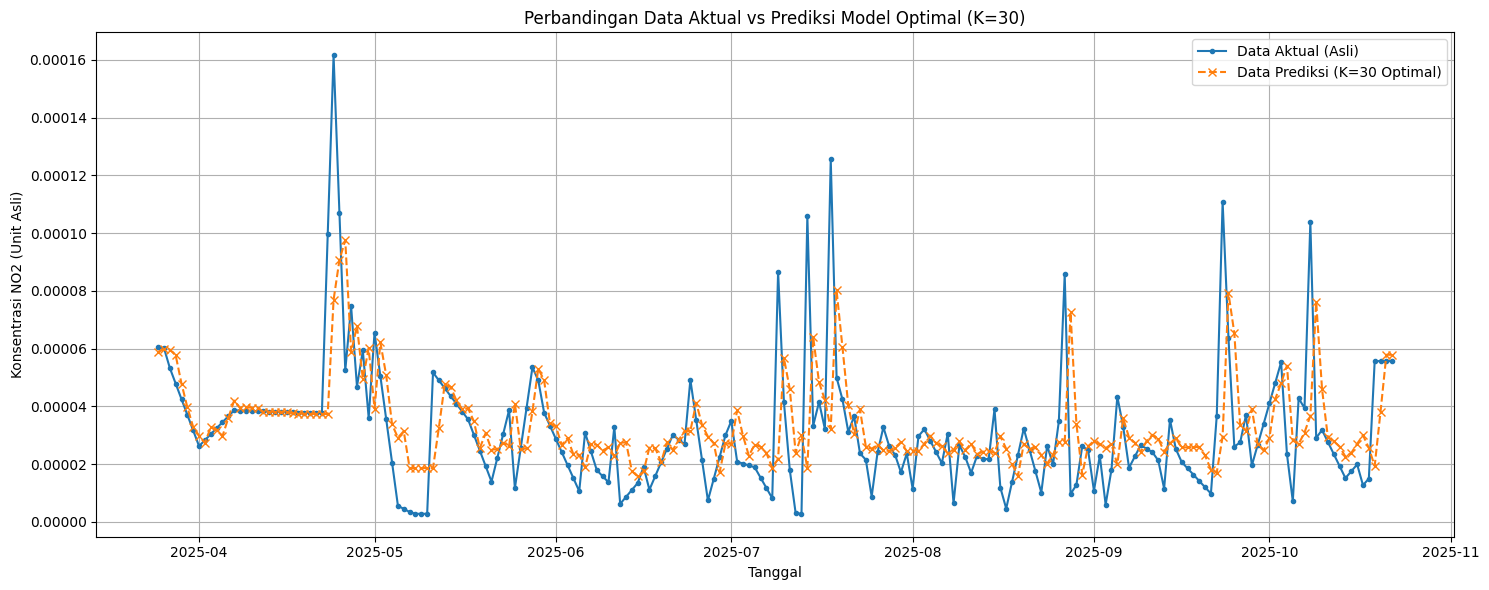

In [17]:
print("\nMembuat visualisasi perbandingan model optimal...")
plt.figure(figsize=(15, 6))
plt.plot(df_results['Tanggal'], df_results['Aktual'], label='Data Aktual (Asli)', marker='.', linestyle='-')
plt.plot(df_results['Tanggal'], df_results['Prediksi'], label=f'Data Prediksi (K={best_k} Optimal)', marker='x', linestyle='--')
plt.title(f'Perbandingan Data Aktual vs Prediksi Model Optimal (K={best_k})')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO2 (Unit Asli)')
plt.legend()
plt.grid(True)
plt.tight_layout()